<a href="https://colab.research.google.com/github/Jafari2018/Certificates/blob/main/Basics%20of%20PyTorch3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# @title Install dependencies
!pip install pandas --quiet
# Imports
import time
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# PyTorch libraries
import torch
from torch import nn
from torchvision import datasets
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor

In [ ]:
# @title Figure Settings
import logging
logging.getLogger('matplotlib.font_manager').disabled = True

import ipywidgets as widgets
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/content-creation/main/nma.mplstyle")

In [ ]:
#Plotting functions
from mpl_toolkits.axes_grid1 import make_axes_locatable

def ex3_plot(model, x, y, ep, lss):
  """
  Plot training loss

  Args:
    model: nn.module
      Model implementing regression
    x: np.ndarray
      Training Data
    y: np.ndarray
      Targets
    ep: int
      Number of epochs
    lss: function
      Loss function

  Returns:
    Nothing
  """
  f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
  ax1.set_title("Regression")
  ax1.plot(x, model(x).detach().numpy(), color='r', label='prediction')
  ax1.scatter(x, y, c='c', label='targets')
  ax1.set_xlabel('x')
  ax1.set_ylabel('y')
  ax1.legend()

  ax2.set_title("Training loss")
  ax2.plot(np.linspace(1, epochs, epochs), losses, color='y')
  ax2.set_xlabel("Epoch")
  ax2.set_ylabel("MSE")

  plt.show()


def ex1_plot(fun_z, fun_dz):
  """
  Plots the function and gradient vectors

  Args:
    fun_z: f.__name__
      Function implementing sine function
    fun_dz: f.__name__
      Function implementing sine function as gradient vector

  Returns:
    Nothing
  """
  x, y = np.arange(-3, 3.01, 0.02), np.arange(-3, 3.01, 0.02)
  xx, yy = np.meshgrid(x, y, sparse=True)
  zz = fun_z(xx, yy)
  xg, yg = np.arange(-2.5, 2.6, 0.5), np.arange(-2.5, 2.6, 0.5)
  xxg, yyg = np.meshgrid(xg, yg, sparse=True)
  zxg, zyg = fun_dz(xxg, yyg)

  plt.figure(figsize=(8, 7))
  plt.title("Gradient vectors point towards steepest ascent")
  contplt = plt.contourf(x, y, zz, levels=20)
  plt.quiver(xxg, yyg, zxg, zyg, scale=50, color='r', )
  plt.xlabel('$x$')
  plt.ylabel('$y$')
  ax = plt.gca()
  divider = make_axes_locatable(ax)
  cax = divider.append_axes("right", size="5%", pad=0.05)
  cbar = plt.colorbar(contplt, cax=cax)
  cbar.set_label('$z = h(x, y)$')

  plt.show()


In [ ]:
# @title Set random seed

# @markdown Executing `set_seed(seed=seed)` you are setting the seed

# For DL its critical to set the random seed so that students can have a
# baseline to compare their results to expected results.
# Read more here: https://pytorch.org/docs/stable/notes/randomness.html

# Call `set_seed` function in the exercises to ensure reproducibility.
import random
import torch

def set_seed(seed=None, seed_torch=True):
  """
  Function that controls randomness. NumPy and random modules must be imported.

  Args:
    seed : Integer
      A non-negative integer that defines the random state. Default is `None`.
    seed_torch : Boolean
      If `True` sets the random seed for pytorch tensors, so pytorch module
      must be imported. Default is `True`.

  Returns:
    Nothing.
  """
  if seed is None:
    seed = np.random.choice(2 ** 32)
  random.seed(seed)
  np.random.seed(seed)
  if seed_torch:
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

  print(f'Random seed {seed} has been set.')


# In case that `DataLoader` is used
def seed_worker(worker_id):
  """
  DataLoader will reseed workers following randomness in
  multi-process data loading algorithm.

  Args:
    worker_id: integer
      ID of subprocess to seed. 0 means that
      the data will be loaded in the main process
      Refer: https://pytorch.org/docs/stable/data.html#data-loading-randomness for more details

  Returns:
    Nothing
  """
  worker_seed = torch.initial_seed() % 2**32
  np.random.seed(worker_seed)
  random.seed(worker_seed)

In [ ]:
# @title Set device (GPU or CPU). Execute `set_device()`
# especially if torch modules used.

# inform the user if the notebook uses GPU or CPU.

def set_device():
  """
  Set the device. CUDA if available, CPU otherwise

  Args:
    None

  Returns:
    Nothing
  """
  device = "cuda" if torch.cuda.is_available() else "cpu"
  if device != "cuda":
    print("GPU is not enabled in this notebook. \n"
          "If you want to enable it, in the menu under `Runtime` -> \n"
          "`Hardware accelerator.` and select `GPU` from the dropdown menu")
  else:
    print("GPU is enabled in this notebook. \n"
          "If you want to disable it, in the menu under `Runtime` -> \n"
          "`Hardware accelerator.` and select `None` from the dropdown menu")

  return device
SEED = 2021
set_seed(seed=SEED)
DEVICE = set_device()


In [ ]:
# @title Helper Functions

def checkExercise1(A, B, C, D):
  """
  Helper function for checking Exercise 1.

  Args:
    A: torch.Tensor
      Torch Tensor of shape (20, 21) consisting of ones.
    B: torch.Tensor
      Torch Tensor of size([3,4])
    C: torch.Tensor
      Torch Tensor of size([20,21])
    D: torch.Tensor
      Torch Tensor of size([19])

  Returns:
    Nothing.
  """
  assert torch.equal(A.to(int),torch.ones(20, 21).to(int)), "Got: {A} \n Expected: {torch.ones(20, 21)} (shape: {torch.ones(20, 21).shape})"
  assert np.array_equal(B.numpy(),np.vander([1, 2, 3], 4)), "Got: {B} \n Expected: {np.vander([1, 2, 3], 4)} (shape: {np.vander([1, 2, 3], 4).shape})"
  assert C.shape == (20, 21), "Got: {C} \n Expected (shape: {(20, 21)})"
  assert torch.equal(D, torch.arange(4, 41, step=2)), "Got {D} \n Expected: {torch.arange(4, 41, step=2)} (shape: {torch.arange(4, 41, step=2).shape})"
  print("All correct")

def timeFun(f, dim, iterations, device='cpu'):
  """
  Helper function to calculate amount of time taken per instance on CPU/GPU

  Args:
    f: BufferedReader IO instance
      Function name for which to calculate computational time complexity
    dim: Integer
      Number of dimensions in instance in question
    iterations: Integer
      Number of iterations for instance in question
    device: String
      Device on which respective computation is to be run

  Returns:
    Nothing
  """
  iterations = iterations
  t_total = 0
  for _ in range(iterations):
    start = time.time()
    f(dim, device)
    end = time.time()
    t_total += end - start

  if device == 'cpu':
    print(f"time taken for {iterations} iterations of {f.__name__}({dim}, {device}): {t_total:.5f}")
  else:
    print(f"time taken for {iterations} iterations of {f.__name__}({dim}, {device}): {t_total:.5f}")

In [ ]:
# We can construct a tensor directly from some common python iterables,
# such as list and tuple nested iterables can also be handled as long as the
# dimensions are compatible

# tensor from a list
a = torch.tensor([0, 1, 2])
#tensor from a tuple of tuples
b = ((1.0, 1.1), (1.2, 1.3))
b = torch.tensor(b)
# tensor from a numpy array
c = np.ones([2, 3])
c = torch.tensor(c)
print(f"Tensor a: {a}")
print(f"Tensor b: {b}")
print(f"Tensor c: {c}")


Tensor a: tensor([0, 1, 2])
Tensor b: tensor([[1.0000, 1.1000],
        [1.2000, 1.3000]])
Tensor c: tensor([[1., 1., 1.],
        [1., 1., 1.]], dtype=torch.float64)


In [ ]:
x = torch.ones(5, 3)
y = torch.zeros(2)
z = torch.empty(1, 1, 5)
print(f"Tensor x: {x}")
print(f"Tensor y: {y}")
print(f"Tensor z: {z}")

Tensor x: tensor([[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]])
Tensor y: tensor([0., 0.])
Tensor z: tensor([[[2.1500e-15, 4.5622e-41, 5.6588e-34, 0.0000e+00, 4.4842e-44]]])


In [ ]:
# There are also constructors for random numbers

# Uniform distribution
a = torch.rand(1, 3)

# Normal distribution
b = torch.randn(3, 4)

# There are also constructors that allow us to construct
# a tensor according to the above constructors, but with
# dimensions equal to another tensor.

c = torch.zeros_like(a)
d = torch.rand_like(c)

print(f"Tensor a: {a}")
print(f"Tensor b: {b}")
print(f"Tensor c: {c}")
print(f"Tensor d: {d}")

Tensor a: tensor([[0.4255, 0.0498, 0.3537]])
Tensor b: tensor([[-0.6633, -2.7065, -0.8703, -0.6429],
        [ 0.3941,  0.5269, -1.5429, -0.5554],
        [ 1.0275,  0.8928,  0.3663,  1.9209]])
Tensor c: tensor([[0., 0., 0.]])
Tensor d: tensor([[0.3926, 0.5708, 0.8214]])


In [ ]:
#Reproducibility of random numbers to seed the  Random Number Generator (RNG) for all devices (both CPU and GPU)
import torch
torch.manual_seed(0)
import random
random.seed(0)
import numpy as np
np.random.seed(0)

In [ ]:
#Here, we define for you a function called set_seed that does the job for you!

def set_seed(seed=None, seed_torch=True):
  """
  Function that controls randomness. NumPy and random modules must be imported.

  Args:
    seed : Integer
      A non-negative integer that defines the random state. Default is `None`.
    seed_torch : Boolean
      If `True` sets the random seed for pytorch tensors, so pytorch module
      must be imported. Default is `True`.

  Returns:
    Nothing.
  """
  if seed is None:
    seed = np.random.choice(2 ** 32)
  random.seed(seed)
  np.random.seed(seed)
  if seed_torch:
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

  print(f'Random seed {seed} has been set.')

In [ ]:
def simplefun(seed=True, my_seed=None):
  """
  Helper function to verify effectiveness of set_seed attribute

  Args:
    seed: Boolean
      Specifies if seed value is provided or not
    my_seed: Integer
      Initializes seed to specified value

  Returns:
    Nothing
  """
  if seed:
    set_seed(seed=my_seed)

  # uniform distribution
  a = torch.rand(1, 3)
  # normal distribution
  b = torch.randn(3, 4)

  print("Tensor a: ", a)
  print("Tensor b: ", b)


In [ ]:
simplefun(seed=True, my_seed=0)  # Turn `seed` to `False` or change `my_seed`

Random seed 0 has been set.
Tensor a:  tensor([[0.4963, 0.7682, 0.0885]])
Tensor b:  tensor([[ 0.3643,  0.1344,  0.1642,  0.3058],
        [ 0.2100,  0.9056,  0.6035,  0.8110],
        [-0.0451,  0.8797,  1.0482, -0.0445]])


In [ ]:
a = torch.arange(0, 10, step=1)
b = np.arange(0, 10, step=1)

c = torch.linspace(0, 5, steps=11)
d = np.linspace(0, 5, num=11)

print(f"Tensor a: {a}\n")
print(f"Numpy array b: {b}\n")
print(f"Tensor c: {c}\n")
print(f"Numpy array d: {d}\n")

Tensor a: tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

Numpy array b: [0 1 2 3 4 5 6 7 8 9]

Tensor c: tensor([0.0000, 0.5000, 1.0000, 1.5000, 2.0000, 2.5000, 3.0000, 3.5000, 4.0000,
        4.5000, 5.0000])

Numpy array d: [0.  0.5 1.  1.5 2.  2.5 3.  3.5 4.  4.5 5. ]



In [ ]:
#Coding Exercise 2.1: Creating Tensors
def tensor_creation(Z):
  """
  A function that creates various tensors.

  Args:
    Z: numpy.ndarray
      An array of shape (3,4)

  Returns:
    A : Tensor
      20 by 21 tensor consisting of ones
    B : Tensor
      A tensor with elements equal to the elements of numpy array Z
    C : Tensor
      A tensor with the same number of elements as A but with values ∼U(0,1)
    D : Tensor
      A 1D tensor containing the even numbers between 4 and 40 inclusive.
  """
  #################################################
  ## TODO for students: fill in the missing code
  ## from the first expression
  ##raise NotImplementedError("Student exercise: say what they should have done")
  #################################################
  A = torch.ones(20, 21)
  B = torch.tensor(Z)
  C = torch.rand_like(A)
  D = torch.arange(4, 41, step=2)

  return A, B, C, D


# numpy array to copy later
Z = np.vander([1, 2, 3], 4)

# Uncomment below to check your function!
A, B, C, D = tensor_creation(Z)
print(f"Tensor D: {D}\n")
#checkExercise1(A, B, C, D)

Tensor D: tensor([ 4,  6,  8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38,
        40])



In [ ]:
#Section 2.2: Operations in PyTorch
a = torch.ones(5, 3)
b = torch.rand(5, 3)
c = torch.empty(5, 3)
d = torch.empty(5, 3)

# this only works if c and d already exist
torch.add(a, b, out=c)

# Pointwise Multiplication of a and b
torch.multiply(a, b, out=d)

print(c)
print(d)

tensor([[1.7932, 1.2643, 1.5500],
        [1.4938, 1.7337, 1.1532],
        [1.5237, 1.9667, 1.8570],
        [1.0044, 1.4247, 1.5047],
        [1.3349, 1.1715, 1.1521]])
tensor([[0.7932, 0.2643, 0.5500],
        [0.4938, 0.7337, 0.1532],
        [0.5237, 0.9667, 0.8570],
        [0.0044, 0.4247, 0.5047],
        [0.3349, 0.1715, 0.1521]])


In [ ]:
x = torch.tensor([1, 2, 4, 8])
y = torch.tensor([1, 2, 3, 4])
x + y, x - y, x * y, x / y, x**y  # The `**` is the exponentiation operator

(tensor([ 2,  4,  7, 12]),
 tensor([0, 0, 1, 4]),
 tensor([ 1,  4, 12, 32]),
 tensor([1.0000, 1.0000, 1.3333, 2.0000]),
 tensor([   1,    4,   64, 4096]))

In [ ]:
#Tensor Methods
x = torch.rand(3, 3)
print(x)
print("\n")
# sum() - note the axis is the axis you move across when summing
print(f"Sum of every element of x: {x.sum()}")
print(f"Sum of the columns of x: {x.sum(axis=0)}")
print(f"Sum of the rows of x: {x.sum(axis=1)}")
print("\n")

print(f"Mean value of all elements of x {x.mean()}")
print(f"Mean values of the columns of x {x.mean(axis=0)}")
print(f"Mean values of the rows of x {x.mean(axis=1)}")

tensor([[0.8322, 0.3381, 0.4678],
        [0.6467, 0.1931, 0.5446],
        [0.7974, 0.2077, 0.6455]])


Sum of every element of x: 4.673100471496582
Sum of the columns of x: tensor([2.2764, 0.7389, 1.6579])
Sum of the rows of x: tensor([1.6382, 1.3844, 1.6505])


Mean value of all elements of x 0.5192334055900574
Mean values of the columns of x tensor([0.7588, 0.2463, 0.5526])
Mean values of the rows of x tensor([0.5461, 0.4615, 0.5502])


In [ ]:
#Matrix Operations
#Coding Exercise 2.2 : Simple tensor operations
def simple_operations(a1: torch.Tensor, a2: torch.Tensor, a3: torch.Tensor):
  """
  Helper function to demonstrate simple operations
  i.e., Multiplication of tensor a1 with tensor a2 and then add it with tensor a3

  Args:
    a1: Torch tensor
      Tensor of size ([2,2])
    a2: Torch tensor
      Tensor of size ([2,2])
    a3: Torch tensor
      Tensor of size ([2,2])

  Returns:
    answer: Torch tensor
      Tensor of size ([2,2]) resulting from a1 multiplied with a2, added with a3
  """
  ################################################
  ## TODO for students:  complete the first computation using the argument matricies
  #raise NotImplementedError("Student exercise: fill in the missing code to complete the operation")
  ################################################
  #
  answer = torch.matmul(a1,a2)+a3
  return answer


# Computing expression 1:

# init our tensors
a1 = torch.tensor([[2, 4], [5, 7]])
a2 = torch.tensor([[1, 1], [2, 3]])
a3 = torch.tensor([[10, 10], [12, 1]])
## uncomment to test your function
A = simple_operations(a1, a2, a3)
print(A)

tensor([[2, 4],
        [5, 7]])
tensor([[20, 24],
        [31, 27]])


In [ ]:
def dot_product(b1: torch.Tensor, b2: torch.Tensor):
  ###############################################
  ## TODO for students:  complete the first computation using the argument matricies
  #raise NotImplementedError("Student exercise: fill in the missing code to complete the operation")
  ###############################################
  """
  Helper function to demonstrate dot product operation
  Dot product is an algebraic operation that takes two equal-length sequences
  (usually coordinate vectors), and returns a single number.
  Geometrically, it is the product of the Euclidean magnitudes of the
  two vectors and the cosine of the angle between them.

  Args:
    b1: Torch tensor
      Tensor of size ([3])
    b2: Torch tensor
      Tensor of size ([3])

  Returns:
    product: Tensor
      Tensor of size ([1]) resulting from b1 scalar multiplied with b2
  """
  # Use torch.dot() to compute the dot product of two tensors
  product = torch.dot(b1, b2)
  return product


# Computing expression 2:
b1 = torch.tensor([3, 5, 7])
b2 = torch.tensor([2, 4, 8])
## Uncomment to test your function
b = dot_product(b1, b2)
print(b)


tensor(82)


In [ ]:
#Indexing is also referred to as slicing.
x = torch.arange(0, 10)
print(x)
print(x[-1])
print(x[1:3])
print(x[:-2])
#When we have multidimensional tensors, indexing rules work the same way as NumPy
# make a 5D tensor
x = torch.rand(1, 2, 3, 4, 5)

print(f" shape of x[0]:{x[0].shape}")
print(f" shape of x[0][0]:{x[0][0].shape}")
print(f" shape of x[0][0][0]:{x[0][0][0].shape}")

#Flatten and reshape
z = torch.arange(12).reshape(6, 2)
print(f"Original z: \n {z}")

# 2D -> 1D
z = z.flatten()
print(f"Flattened z: \n {z}")

# and back to 2D
z = z.reshape(3, 4)
print(f"Reshaped (3x4) z: \n {z}")

#Squeezing tensors to deal with singleton dimensions. E.g., [1,10] or [256, 1, 3]
#In order to compress tensors along their singleton dimensions we can use the .squeeze() method
x = torch.randn(1, 10)
# printing the zeroth element of the tensor will not give us the first number!

print(x.shape)
print(f"x[0]: {x[0]}")
#Because of that pesky singleton dimension, x[0] gave us the first row instead!
# Let's get rid of that singleton dimension and see what happens now
x = x.squeeze(0)
print(x.shape)
print(f"x[0]: {x[0]}")
# Adding singleton dimensions works a similar way, and is often used when tensors
# being added need same number of dimensions

y = torch.randn(5, 5)
print(f"Shape of y: {y.shape}")

# lets insert a singleton dimension
y = y.unsqueeze(1)
print(f"Shape of y: {y.shape}")

# Permutation
#we may be dealing with RGB images with dim [3×48×64]
#, but our pipeline expects the colour dimension to be the last dimension, i.e., [48×64×3]
# To get around this we can use the .permute() method.

# `x` has dimensions [color,image_height,image_width]
x = torch.rand(3, 48, 64)

# We want to permute our tensor to be [ image_height , image_width , color ]
x = x.permute(1, 2, 0)
# permute(1,2,0) means:
# The 0th dim of my new tensor = the 1st dim of my old tensor
# The 1st dim of my new tensor = the 2nd
# The 2nd dim of my new tensor = the 0th
print(x.shape)

# Concatenation
#In this example, we concatenate two matrices along rows (axis 0, the first element of the shape)
# vs. columns (axis 1, the second element of the shape).
# Create two tensors of the same shape
x = torch.arange(12, dtype=torch.float32).reshape((3, 4))
y = torch.tensor([[2.0, 1, 4, 3], [1, 2, 3, 4], [4, 3, 2, 1]])

# Concatenate along rows
cat_rows = torch.cat((x, y), dim=0)

# Concatenate along columns
cat_cols = torch.cat((x, y), dim=1)

# Printing outputs
print('Concatenated by rows: shape{} \n {}'.format(list(cat_rows.shape), cat_rows))
print('\n Concatenated by colums: shape{}  \n {}'.format(list(cat_cols.shape), cat_cols))

#Converting a tensor to a numpy.ndarray, or vice versa
#This minor inconvenience is quite important: when you perform operations on the CPU or GPUs,
#you do not want to halt computation, waiting to see whether the NumPy package of Python might
#want to be doing something else with the same chunk of memory.
x = torch.randn(5)
print(f"x: {x}  |  x type:  {x.type()}")

y = x.numpy()
print(f"y: {y}  |  y type:  {type(y)}")

z = torch.tensor(y)
print(f"z: {z}  |  z type:  {z.type()}")

#To convert a size-1 tensor to a Python scalar, we can invoke the item function or Python’s built-in functions.
a = torch.tensor([3.5])
a, a.item(), float(a), int(a)


tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
tensor(9)
tensor([1, 2])
tensor([0, 1, 2, 3, 4, 5, 6, 7])


In [ ]:
#Coding Exercise 2.3: Manipulating Tensors
def functionA(my_tensor1, my_tensor2):
  """
  This function takes in two 2D tensors `my_tensor1` and `my_tensor2`
  and returns the column sum of
  `my_tensor1` multiplied by the sum of all the elmements of `my_tensor2`,
  i.e., a scalar.

  Args:
    my_tensor1: torch.Tensor
    my_tensor2: torch.Tensor

  Returns:
    output: torch.Tensor
      The multiplication of the column sum of `my_tensor1` by the sum of
      `my_tensor2`.
  """
  # TODO multiplication the sum of the tensors
  output = my_tensor1.sum(axis=0) * my_tensor2.sum()

  return output


def functionB(my_tensor):
  """
  This function takes in a square matrix `my_tensor` and returns a 2D tensor
  consisting of a flattened `my_tensor` with the index of each element
  appended to this tensor in the row dimension.

  Args:
    my_tensor: torch.Tensor

  Returns:
    output: torch.Tensor
      Concatenated tensor.
  """
  # TODO flatten the tensor `my_tensor`
  my_tensor = my_tensor.flatten()
  # TODO create the idx tensor to be concatenated to `my_tensor`
  idx_tensor = torch.arange(0, len(my_tensor))
  # TODO concatenate the two tensors
  output = torch.cat([idx_tensor.unsqueeze(1), my_tensor.unsqueeze(1)], axis=1)

  return output


def functionC(my_tensor1, my_tensor2):
  """
  This function takes in two 2D tensors `my_tensor1` and `my_tensor2`.
  If the dimensions allow it, it returns the
  elementwise sum of `my_tensor1`-shaped `my_tensor2`, and `my_tensor2`;
  else this function returns a 1D tensor that is the concatenation of the
  two tensors.

  Args:
    my_tensor1: torch.Tensor
    my_tensor2: torch.Tensor

  Returns:
    output: torch.Tensor
      Concatenated tensor.
  """
  # TODO check we can reshape `my_tensor2` into the shape of `my_tensor1`
  if torch.numel(my_tensor1) == torch.numel(my_tensor2):
    # TODO reshape `my_tensor2` into the shape of `my_tensor1`
    my_tensor2 = my_tensor2.reshape(my_tensor1.shape)
    # TODO sum the two tensors
    output = my_tensor1 + my_tensor2
  else:
    # TODO flatten both tensors. -1 means remove that dimension
    my_tensor1 = my_tensor1.reshape(1, -1)
    my_tensor2 = my_tensor2.reshape(1, -1)
    # TODO concatenate the two tensors in the correct dimension
    output = torch.cat([my_tensor1, my_tensor2], axis=1).squeeze()

  return output


## Implement the functions above and then uncomment the following lines to test your code
print(functionA(torch.tensor([[1, 1], [1, 1]]), torch.tensor([[1, 2, 3], [1, 2, 3]])))
print(functionB(torch.tensor([[2, 3], [-1, 10]])))
print(functionC(torch.tensor([[1, -1], [-1, 3]]), torch.tensor([[2, 3, 0, 2]])))
print(functionC(torch.tensor([[1, -1], [-1, 3]]), torch.tensor([[2, 3, 0]])))

tensor([24, 24])
tensor([[ 0,  2],
        [ 1,  3],
        [ 2, -1],
        [ 3, 10]])
tensor([[ 3,  2],
        [-1,  5]])
tensor([ 1, -1, -1,  3,  2,  3,  0])


In [ ]:
#Coding Exercise 2.4: Just how much faster are GPUs?
#CPU or GPU specified by the parameter device
dim = 10000
iterations = 1
def simpleFun(dim, device):
  """
  Helper function to check device-compatiblity with computations

  Args:
    dim: Integer
    device: String
      "cpu" or "cuda"

  Returns:
    Nothing.
  """
  # 2D tensor filled with uniform random numbers in [0,1), dim x dim
  x = torch.rand(dim, dim).to(device)
  # 2D tensor filled with uniform random numbers in [0,1), dim x dim
  y = torch.rand_like(x).to(device)
  # 2D tensor filled with the scalar value 2, dim x dim
  z = 2*torch.ones(dim, dim).to(device)

  # elementwise multiplication of x and y
  a = x * y
  # matrix multiplication of x and z
  b = x @ z

  del x
  del y
  del z
  del a
  del b


## Implement the function above and uncomment the following lines to test your code
timeFun(f=simpleFun, dim=dim, iterations=iterations)
timeFun(f=simpleFun, dim=dim, iterations=iterations, device=DEVICE)

NameError: ignored

In [ ]:
# Section 2.5: Datasets and Dataloaders
# Import dataset and dataloaders related packages
# The torchvision package gives you easy access to many of the publicly available datasets.
# the CIFAR10 dataset, which contains color images of 10 different classes, like vehicles and animals.
# Creating an object of type datasets.CIFAR10 will automatically download and load all images from the dataset.
# The resulting data structure can be treated as a list containing data samples and their corresponding labels.
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
from torchvision.transforms import Compose, Grayscale


In [ ]:
# Download and load the images from the CIFAR10 dataset
cifar10_data = datasets.CIFAR10(
    root="data",  # path where the images will be stored
    download=True,  # all images should be downloaded
    transform=ToTensor()  # transform the images to tensors
    )

# Print the number of samples in the loaded dataset
print(f"Number of samples: {len(cifar10_data)}")
print(f"Class names: {cifar10_data.classes}")

100%|██████████| 170498071/170498071 [00:04<00:00, 34616138.02it/s]


Extracting data/cifar-10-python.tar.gz to data
Number of samples: 50000
Class names: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [ ]:
# Choose a random sample
random.seed(2021)
image, label = cifar10_data[random.randint(0, len(cifar10_data))]
#Color images are modeled as 3 dimensional tensors. The first dimension corresponds to the channels (C
#) of the image (in this case we have RGB images). The second dimensions is the height (H
#) of the image and the third is the width (W
#). We can denote this image format as C×H×W
print(f"Label: {cifar10_data.classes[label]}")
print(f"Image size: {image.shape}")

Label: horse
Image size: torch.Size([3, 32, 32])


torch.Size([2, 4])
tensor([[-0.0770, -1.6534,  0.3634, -0.1355],
        [ 0.9027, -1.3745, -0.4260,  0.7094]])
torch.Size([4, 2])
tensor([[-0.0770,  0.9027],
        [-1.6534, -1.3745],
        [ 0.3634, -0.4260],
        [-0.1355,  0.7094]])


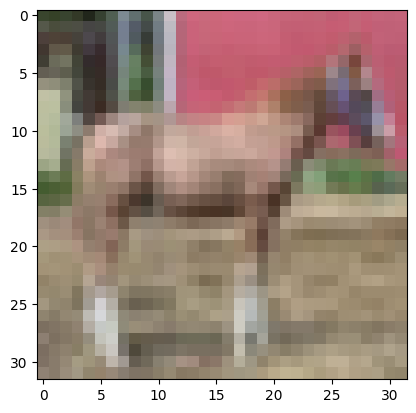

In [ ]:
# Coding Exercise 2.5: Display an image from the dataset
# Let’s try to display the image using matplotlib.
#  The imshow expects to have the image in a different format, i.e., C×H×W
# You need to reorder the dimensions of the tensor using the permute method of the tensor
# The size of the returned tensor remains the same as that of the original.

# create a tensor of size 2 x 4
input_var = torch.randn(2, 4)
# print its size and the tensor
print(input_var.size())
print(input_var)

# dimensions permuted
input_var = input_var.permute(1, 0)
# print its size and the permuted tensor
print(input_var.size())
print(input_var)

# TODO: Uncomment the following line to see the error that arises from the current image format
# TODO: Comment the above line and fix this code by reordering the tensor dimensions
#plt.imshow(image)
plt.imshow(image.permute(1, 2, 0))
plt.show()





In [ ]:

# Load the training samples
training_data = datasets.CIFAR10(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
    )

# Load the test samples
test_data = datasets.CIFAR10(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
    )

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
# Dataloader
#  It is a wrapper around the Dataset that splits it into minibatches
# (important for training the neural network) and makes the data iterable
#  The shuffle argument is used to shuffle the order of the samples across the minibatches
# Create dataloaders with
train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)
# Reproducibility: DataLoader will reseed workers following Randomness
# in multi-process data loading algorithm. Use worker_init_fn() and a generator to preserve reproducibility
def seed_worker(worker_id):
  worker_seed = torch.initial_seed() % 2**32
  numpy.random.seed(worker_seed)
  my_seed=random.seed(worker_seed)


g_seed = torch.Generator()
g_seed.manual_seed(my_seed)

DataLoader(
    train_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    worker_init_fn=seed_worker,
    generator=g_seed
    )
#Important: For the seed_worker to have an effect, num_workers should be 2 or more.


NameError: ignored

Batch size: torch.Size([64, 3, 32, 32])


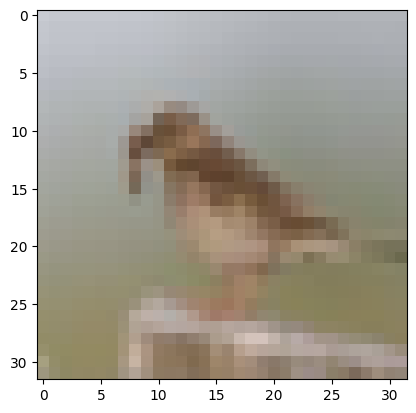

In [ ]:
# Load the next batch
batch_images, batch_labels = next(iter(train_dataloader))
print('Batch size:', batch_images.shape)

# Display the first image from the batch
plt.imshow(batch_images[0].permute(1, 2, 0))
plt.show()

Files already downloaded and verified


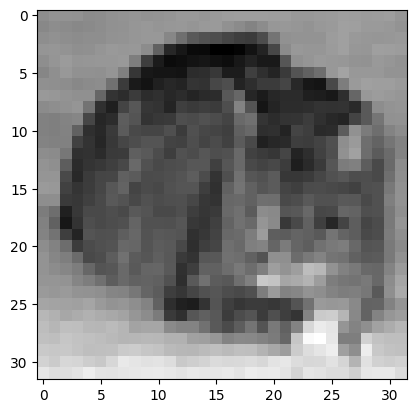

In [ ]:
# Transformations
# There are many predefined transformations in the torchvision.transforms package and you can also combine them using the Compose transform.
# Coding Exercise 2.6: Load the CIFAR10 dataset as grayscale images
def my_data_load():
  """
  Function to load CIFAR10 data as grayscale images

  Args:
    None

  Returns:
    data: DataFrame
      CIFAR10 loaded Dataframe of shape (3309, 14)
  """
  ## TODO Load the CIFAR10 data using a transform that converts the images to grayscale tensors
  data = datasets.CIFAR10(root="data", download=True,
                          transform=Compose([ToTensor(), Grayscale()]))
  # Display a random grayscale image
  image, label = data[random.randint(0, len(data))]
  plt.imshow(image.squeeze(), cmap="gray")
  plt.show()

  return data


#set_seed(seed=2021)
## After implementing the above code, uncomment the following lines to test your code
data = my_data_load()

In [ ]:
# Section 3: Neural Networks
# Creating a simple neural network model
# Training the network
# Visualizing the results of the network
# Tweaking the network
# Generate sample data-  load the data from the CSV file using the Pandas library
# in Pandas  we can reference the columns directly by their names
# Load the data from the CSV file in a Pandas DataFrame
data = pd.read_csv("sample_data.csv")

# Create a 2D numpy array from the x0 and x1 columns
X_orig = data[["x0", "x1"]].to_numpy()

# Create a 1D numpy array from the y column
y_orig = data["y"].to_numpy()

# Print the sizes of the generated 2D points X and the corresponding labels Y
print(f"Size X:{X_orig.shape}")
print(f"Size y:{y_orig.shape}")

# Visualize the dataset. The color of the points is determined by the labels `y_orig`.
plt.scatter(X_orig[:, 0], X_orig[:, 1], s=40, c=y_orig)
plt.show()

FileNotFoundError: ignored

In [ ]:
# Prepare Data for PyTorch- convert everything into tensors.
# Initialize the device variable
DEVICE = set_device()

# Convert the 2D points to a float32 tensor
X = torch.tensor(X_orig, dtype=torch.float32)

# Upload the tensor to the device
X = X.to(DEVICE)

print(f"Size X:{X.shape}")

# Convert the labels to a long interger tensor
y = torch.from_numpy(y_orig).type(torch.LongTensor)

# Upload the tensor to the device
y = y.to(DEVICE)

print(f"Size y:{y.shape}")


NameError: ignored

In [ ]:
# Section 3.2: Create a Simple Neural Network
# Inherit from nn.Module - the base class for neural network modules provided by Pytorch
# PyTorch provides a base class for all neural network modules called nn.Module

class NaiveNet(nn.Module):
  """
  NaiveNet architecture
  Structure is as follows:
  Linear Layer (2, 16) -> ReLU activation -> Linear Layer (16, 2)
  """
  # Define the structure of your network
  def __init__(self):
    """
    Defines the NaiveNet structure by initialising following attributes
    nn.Linear (2, 16):  Transformation from the input to the hidden layer
    nn.ReLU: Activation function (ReLU) is a non-linearity which is widely used because it reduces computation.
             The function returns 0 if it receives any negative input, but for any positive value x, it returns that value back.
    nn.Linear (16, 2): Transformation from the hidden to the output layer

    Args:
      None

    Returns:
      Nothing
    """
    ## call superclass
    super(NaiveNet, self).__init__()

    # The network is defined as a sequence of operations
    self.layers = nn.Sequential(
        nn.Linear(2, 16),
        nn.ReLU(),
        nn.Linear(16, 2),
    )

  # Specify the computations performed on the data
  def forward(self, x):
    """
    Defines the forward pass through the above defined structure

    Args:
      x: torch.Tensor
        Input tensor of size ([3])

    Returns:
      layers: nn.module
        Initialised Layers in order to re-use the same layer for each forward pass of data you make.
    """
    # Pass the data through the layers
    return self.layers(x)

  # Choose the most likely label predicted by the network
  def predict(self, x):
    """
    Performs the prediction task of the network

    Args:
      x: torch.Tensor
        Input tensor of size ([3])

    Returns:
      Most likely class i.e., Label with the highest score
    """
    # Pass the data through the networks
    output = self.forward(x)

    # Choose the label with the highest score
    return torch.argmax(output, 1)

  # Train the neural network (will be implemented later)
  def train(self, X, y):
    """
    Training the Neural Network

    Args:
      X: torch.Tensor
        Input data
      y: torch.Tensor
        Class Labels/Targets

    Returns:
      Nothing
    """
    pass

In [ ]:
# Check that your network works
# Create an instance of your model and visualize it
# Create new NaiveNet and transfer it to the device
model = NaiveNet()
#.to(DEVICE)

# Print the structure of the network
print(model)

NaiveNet(
  (layers): Sequential(
    (0): Linear(in_features=2, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=2, bias=True)
  )
)


In [ ]:
# Coding Exercise 3.2: Classify some samples
## Get the samples
X_samples = X[0:5]
print("Sample input:\n", X_samples)

## Do a forward pass of the network
output = model.forward(X_samples)
print("\nNetwork output:\n", output)

## Predict the label of each point
y_predicted = model.predict(X_samples)
print("\nPredicted labels:\n", y_predicted)

NameError: ignored

In [ ]:
# Section 3.3: Train Your Neural Network
# Implement the train function given a training dataset X and correcsponding labels y
def train(model, X, y):
  """
    Training the Neural Network

    Args:
      X: torch.Tensor
        Input data
      y: torch.Tensor
        Class Labels/Targets

    Returns:
      losses: Float
        Cross Entropy Loss; Cross-entropy builds upon the idea of entropy
        from information theory and calculates the number of bits required
        to represent or transmit an average event from one distribution
        compared to another distribution.
    """
  # The Cross Entropy Loss is suitable for classification problems
  loss_function = nn.CrossEntropyLoss()

  # Create an optimizer (Stochastic Gradient Descent) that will be used to train the network
  learning_rate = 1e-2
  optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

  # Number of epochs
  epochs = 15000

  # List of losses for visualization
  losses = []

  for i in range(epochs):
    # Pass the data through the network and compute the loss
    # We'll use the whole dataset during the training instead of using batches
    # in to order to keep the code simple for now.
    y_logits = model.forward(X)
    loss = loss_function(y_logits, y)

    # Clear the previous gradients and compute the new ones
    optimizer.zero_grad()
    loss.backward()

    # Adapt the weights of the network
    optimizer.step()

    # Store the loss
    losses.append(loss.item())

    # Print the results at every 1000th epoch
    if i % 1000 == 0:
      print(f"Epoch {i} loss is {loss.item()}")

      plot_decision_boundary(model, X, y, DEVICE)
      plt.savefig('frames/{:05d}.png'.format(i))

  return losses


# Create a new network instance a train it
model = NaiveNet().to(DEVICE)
losses = train(model, X, y)

In [ ]:
#Plot the loss during the training to see how it reduces and converges
plt.plot(np.linspace(1, len(losses), len(losses)), losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
Text(0, 0.5, 'Loss')

In [ ]:
#Visualize the training process
# @title Visualize the training process
# @markdown Execute this cell!
!pip install imageio --quiet
!pip install pathlib --quiet

import imageio.v2 as imageio
from IPython.core.interactiveshell import InteractiveShell
from IPython.display import Image, display
from pathlib import Path

InteractiveShell.ast_node_interactivity = "all"

# Make a list with all images
images = []
for i in range(10):
  filename = Path("frames/0"+str(i)+"000.png")
  images.append(imageio.imread(filename))
# Save the gif
imageio.mimsave('frames/movie.gif', images)
gifPath = Path("frames/movie.gif")
with open(gifPath,'rb') as f:
  display(Image(data=f.read(), format='png'))

In [ ]:
"""
Typically:
1. Training for longer number of epochs tends to increase performance (but early stopping also works in some cases).
2. Increased size of hidden layers aka width increases capacity leading to double descent.
3. Increasing number of hidden layers aka depth typically makes the network more expressive (but networks that're very deep overfit).
""";